In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import linear_model, ensemble
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style='whitegrid', font_scale=1.3)

In [2]:
#set seaborn plot display options
sns.set(style='whitegrid', palette='muted', font_scale=1.3)

#color variables incase they're needed
color_b = sns.color_palette('muted').as_hex()[0]
color_g = sns.color_palette('muted').as_hex()[1]
color_r = sns.color_palette('muted').as_hex()[2]
color_p = sns.color_palette('muted').as_hex()[3]
color_y = sns.color_palette('muted').as_hex()[4]
color_c = sns.color_palette('muted').as_hex()[5]

# 0. Introduction

## 0.1 Research Proposal
- __Goal:__ predict house sale prices
- Why is this a good topic to study?
- What are some challenges to this topic?

## 0.2 Method
1. Develop & train a model to predict saleprice
2. Evaluation method: root mean squared error (RMSE) between the log of the predicted value and the log of the observed sales price
3. RMSE: absolute measure of fit, can compare across different models (r-squared is relative fit, increases as model complexity grows, so cannot compare across models)

# 1. Dataset: Ames, Iowa Housing Market Data

## 1.1 Dataset background

__Abstract Excerpt:__

This paper presents a data set describing the sale of individual residential property in Ames, Iowa from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home values.

__Full Description:__

https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

__Data Source:__

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

Kaggle API: >_ kaggle competitions download -c house-prices-advanced-regression-techniques

## 1.2 Upload Data

In [3]:
train_raw = pd.read_csv('train.csv')
#train_raw.head()

In [4]:
#train_raw.describe()

In [5]:
#train_raw.columns

# 2. EDA, Data Preprocessing, and Feature Selection/Engineering

## 2.1 Basic Cleaning

In [6]:
#set df to manipulate, leave raws accessible
train = train_raw.copy()

#lowercase column names
train.columns = [x.lower() for x in train.columns]

#strip whitespace
to_strip = train.select_dtypes(include='object')
train[to_strip.columns] = to_strip.apply(lambda x: x.str.strip())

## 2.2 Outliers

The [dataset documentation](https://ww2.amstat.org/publications/jse/v19n3/decock.pdf) points out a few problematic outliers, and recommends removing records where grlivarea > 4000

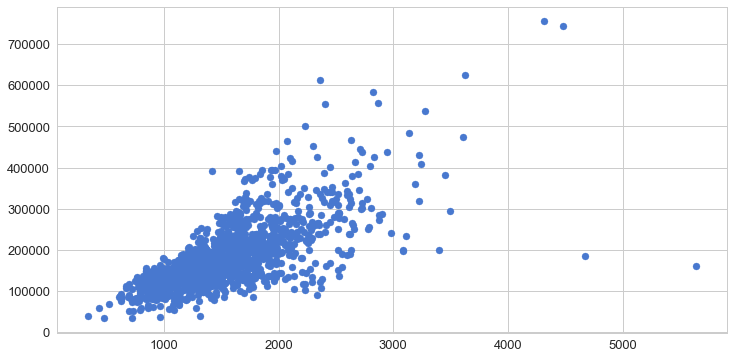

In [7]:
plt.figure(figsize=(12,6))
plt.scatter(train['grlivarea'], train['saleprice'])
plt.show()

In [8]:
train = train[train.grlivarea < 4000]
print(train.grlivarea.max())

3627


## 2.3 Missingness

In [9]:
#see whats missing
missing_data = train.isnull().sum().sort_values(ascending=False)
missing_data = missing_data.reset_index()
missing_data.columns = ['variable','rows_missing']
missing_data = missing_data[missing_data['rows_missing'] > 0]
missing_data

,variable,rows_missing
0,poolqc,1451
1,miscfeature,1402
2,alley,1365
3,fence,1176
4,fireplacequ,690
5,lotfrontage,259
6,garagecond,81
7,garagetype,81
8,garageyrblt,81
9,garagefinish,81


### Missing value handling: NA indicates lack of feature

- poolqc: pool quality
- miscfeature: miscellaneous feature not covered in other categories
- alley: type of alley access to property
- fence: fence quality
- fireplacequ: fireplace quality
- garagecond: garage condition
- garagetype: garage location
- garageyrblt: year garage was built
- garagefinish: interior finish of garage
- garagequal: garage quality
- bsmtexposure: refers to walkout or garden level walls
- bsmtfintype1: rating of basement finished area
- bsmtfintype2: rating of basement finished area (if multiple types)
- bsmtcond: evaluates the general condition of the basement
- bsmtqual: evaluates the height of the basement (in inches, Excellent >= 100, Poor < 70)
- masvnrtype: masonry veneer type
- masvnrarea: masonry veneer area in square feet

__Action:__ impute no_feature or 0 (descriptions are available in the 'data_description.txt' file)

In [10]:
#handle missing values, easy part
train['poolqc'].fillna('no_pool', inplace=True)
train['miscfeature'].fillna('no_miscfeat', inplace=True)
train['alley'].fillna('no_access', inplace=True)
train['fence'].fillna('no_fence', inplace=True)
train['fireplacequ'].fillna('no_fireplace', inplace=True)
train['garagecond'].fillna('no_garage', inplace=True)
train['garagetype'].fillna('no_garage', inplace=True)
train['garagefinish'].fillna('no_garage', inplace=True)
train['garagequal'].fillna('no_garage', inplace=True)
train['garageyrblt'].fillna(0, inplace=True)
train['bsmtexposure'].fillna('no_bsmt', inplace=True)
train['bsmtfintype1'].fillna('no_bsmt', inplace=True)
train['bsmtfintype2'].fillna('no_bsmt', inplace=True)
train['bsmtcond'].fillna('no_bsmt', inplace=True)
train['bsmtqual'].fillna('no_bsmt', inplace=True)
train['masvnrtype'].fillna('no_masvnr', inplace=True)
train['masvnrarea'].fillna(0, inplace=True)

### Missing value handling: electrical variable
electrical: electrical system, can be one of the following
- SBrkr: Standard Circuit Breakers & Romex
- FuseA: Fuse Box over 60 AMP and all Romex wiring (Average)	
- FuseF: 60 AMP Fuse Box and mostly Romex wiring (Fair)
- FuseP: 60 AMP Fuse Box and mostly knob elect & tube wiring (poor)
- Mix: Mixed

In [11]:
print(train['electrical'].value_counts(dropna=False))

SBrkr    1330
FuseA      94
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: electrical, dtype: int64


In [12]:
#impute with most common value
train['electrical'].fillna('SBrkr', inplace=True)
print(train['electrical'].value_counts(dropna=False))

SBrkr    1331
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: electrical, dtype: int64


### Missing value handling: variable lotfrontage
lotfrontage: linear feet of street connected to property

In [13]:
print(train['lotfrontage'].value_counts(
    dropna=False).sort_values(ascending=False).head())

NaN      259
 60.0    143
 70.0     70
 80.0     69
 50.0     57
Name: lotfrontage, dtype: int64


Hard to believe that 259 residential properties were sold without connecting to a street
- check against street access
- check against lotarea
- come up with strategy to impute

In [14]:
print('street value counts:')
print(train['street'].value_counts(dropna=False))
print('\nlotarea null values: ')

print(train['lotarea'].isnull().sum())
#make sure there aren't unreasonably small lot sizes, could indicate data error
print('\nlotarea smallest lots')
print(train['lotarea'].value_counts(dropna=False).sort_index().head())

street value counts:
Pave    1450
Grvl       6
Name: street, dtype: int64

lotarea null values: 
0

lotarea smallest lots
1300    1
1477    1
1491    1
1526    1
1533    2
Name: lotarea, dtype: int64


- Variables street and lotarea have no missing values
- Since every record has some street access and lot square footage, lotfrontage nulls should be filled with something

Could simply impute the mean, but we can be more creative than that:
- investigate the relationship between lotfrontage and lotarea
- Use this proportion to estimate lotfrontage from lotarea

In [15]:
temp_df = train.loc[:, (train.columns).isin(['lotfrontage', 'lotarea'])]
temp_df['ratio'] = temp_df['lotfrontage'] / temp_df['lotarea']

print('lotfrontage:lotarea proportion:')
print('ratio mean: %.5f' % temp_df['ratio'].dropna().mean())
print('ratio median: %.5f' % temp_df['ratio'].dropna().median())
print('ratio mode: %.5f' % temp_df['ratio'].dropna().mode())

lotfrontage:lotarea proportion:
ratio mean: 0.00791
ratio median: 0.00771
ratio mode: 0.00833


- Mean, median, and mode are all about 0.008
- Impute lotfrontage nulls with their lotarea * mean ratio to estimate lotfrontage

In [16]:
ratio_mean = (train['lotfrontage'] / train['lotarea']).mean()
train['lotfrontage'].fillna(train['lotarea'] * ratio_mean, inplace=True)
train['lotfrontage'].isnull().sum()

0

## 2.4 Feature Engineering
- drop 'id' column, no helpful data, just record id numbers
- mosold and yrsold are currently separate features, combine into single feature
- variable correlations:
    - corr with sale price
    - multicollinearity
    - create features/PCA as necessary

In [17]:
#drop id column
train = train.drop(['id'], 1)

In [18]:
#create yr/mo sold feature
train['mosold'] = train['mosold'].apply('{:0>2}'.format)
train['yrmo_sold'] = train.yrsold.astype(
    str).str.cat(train.mosold.astype(str)).astype(int)

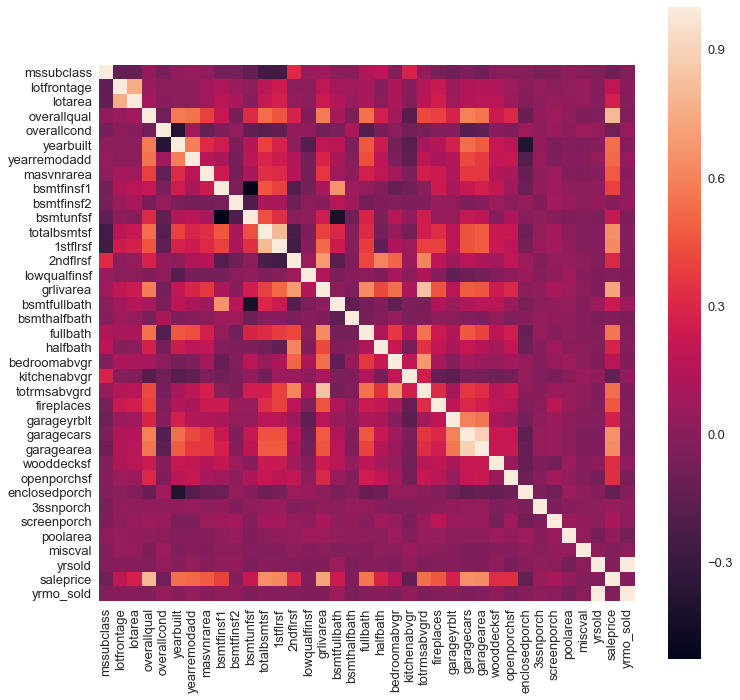

In [19]:
corrmat = train.corr()

plt.figure(figsize=(12,12))
sns.heatmap(corrmat, square=True)
plt.show()

In [21]:
feats_corr = corrmat['saleprice'].sort_values(ascending=False).tail(-1)
feats_corr = feats_corr[feats_corr > 0]
feats_corr

overallqual     0.800858
grlivarea       0.720516
garagecars      0.649256
totalbsmtsf     0.646584
garagearea      0.636964
1stflrsf        0.625235
fullbath        0.559048
totrmsabvgrd    0.537462
yearbuilt       0.535279
yearremodadd    0.521428
masvnrarea      0.473650
fireplaces      0.466765
bsmtfinsf1      0.395923
openporchsf     0.330361
wooddecksf      0.322538
2ndflrsf        0.297301
halfbath        0.282925
lotarea         0.269866
garageyrblt     0.268332
bsmtfullbath    0.235697
bsmtunfsf       0.220678
lotfrontage     0.189977
bedroomabvgr    0.160542
screenporch     0.118324
3ssnporch       0.047414
poolarea        0.032819
Name: saleprice, dtype: float64

__Square footage variables:__ grlivarea, totalbsmtsf, garagearea, 1stflrsf, bsmtfinsf1, openporchsf, wooddecksf, 2ndflrsf, bsmtunfsf are all positively correlated with saleprice to different extents
- Drop garagearea: garagecars and garagearea say essentially the same thing, garagecars has higher correlation with saleprice and is a better measure of garage usefulness
- Check collinearity of sf variables, remove and/or create features as necessary

In [20]:
train = train.drop('garagearea', 1)

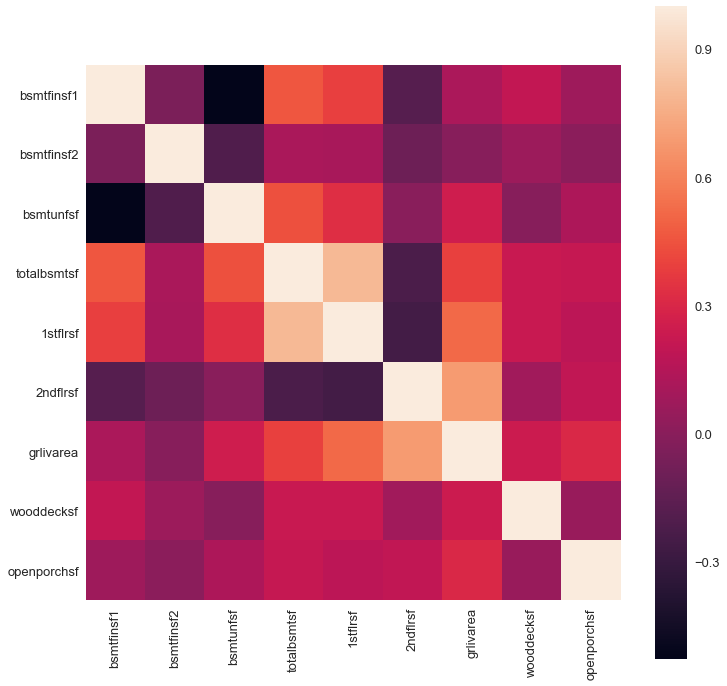

In [22]:
#even though its not in this list, include bsmtfinsf2 here
sf_vars = train.loc[:, (train.columns).isin(['grlivarea', 'totalbsmtsf',
                                             '1stflrsf', 'bsmtfinsf1',
                                             'openporchsf', 'wooddecksf',
                                             '2ndflrsf', 'bsmtunfsf',
                                             'bsmtfinsf2'])]

plt.figure(figsize=(12,12))
sns.heatmap(sf_vars.corr(), square=True)
plt.show()

In [23]:
c = sf_vars.corr()
s = c.unstack()
so = pd.DataFrame(s.sort_values(ascending=False))
so = so.reset_index()
so.columns = ['var1', 'var2', 'corr']
so = so[so['corr'] < 1]
so = so[so['corr'] > 0]
so.drop_duplicates(subset='corr', keep='first', inplace=True)
so.sort_values(by='corr', ascending=False)

,var1,var2,corr
9,totalbsmtsf,1stflrsf,0.800759
11,2ndflrsf,grlivarea,0.687430
13,grlivarea,1stflrsf,0.522920
15,bsmtfinsf1,totalbsmtsf,0.460324
17,bsmtunfsf,totalbsmtsf,0.441625
19,totalbsmtsf,grlivarea,0.394829
21,bsmtfinsf1,1stflrsf,0.386453
23,bsmtunfsf,1stflrsf,0.331574
25,openporchsf,grlivarea,0.307325
27,grlivarea,bsmtunfsf,0.251632


### New features to create:
- finished basement sf (bsmtfinsf1 + bsmtfinsf2)
- ~~¿ maybe finished basement (1) or not finished (0) based on totalbsmtsf vs. finished & unfinished~~ - this is covered under bsmtfintype variables
- PCA opportunity between grlivarea, 1stflrsf, 2ndflrsf, totalbsmtsf?

In [24]:
#first make sure current sf variables add up as expected
print((train['bsmtfinsf1'] + train['bsmtfinsf2'] + train['bsmtunfsf'] == train['totalbsmtsf']).value_counts(dropna=False))
print((train['1stflrsf'] + train['2ndflrsf'] + train['lowqualfinsf'] == train['grlivarea']).value_counts(dropna=False))

True    1456
dtype: int64
True    1456
dtype: int64


In [25]:
#create bsmtfinsf_total
train['bsmtfinsf_total'] = train['bsmtfinsf1'] + train['bsmtfinsf2']

#drop original bsmt columns
train = train.loc[:, ~(train.columns).isin(['bsmtfinsf1', 'bsmtfinsf2'])]

train.head()

,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,...,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,yrmo_sold,bsmtfinsf_total
0,60,RL,65.0,8450,Pave,no_access,Reg,Lvl,AllPub,Inside,...,no_fence,no_miscfeat,0,02,2008,WD,Normal,208500,200802,706
1,20,RL,80.0,9600,Pave,no_access,Reg,Lvl,AllPub,FR2,...,no_fence,no_miscfeat,0,05,2007,WD,Normal,181500,200705,978
2,60,RL,68.0,11250,Pave,no_access,IR1,Lvl,AllPub,Inside,...,no_fence,no_miscfeat,0,09,2008,WD,Normal,223500,200809,486
3,70,RL,60.0,9550,Pave,no_access,IR1,Lvl,AllPub,Corner,...,no_fence,no_miscfeat,0,02,2006,WD,Abnorml,140000,200602,216
4,60,RL,84.0,14260,Pave,no_access,IR1,Lvl,AllPub,FR2,...,no_fence,no_miscfeat,0,12,2008,WD,Normal,250000,200812,655


## 2.5 Variable Distributions

### Target Variable: saleprice

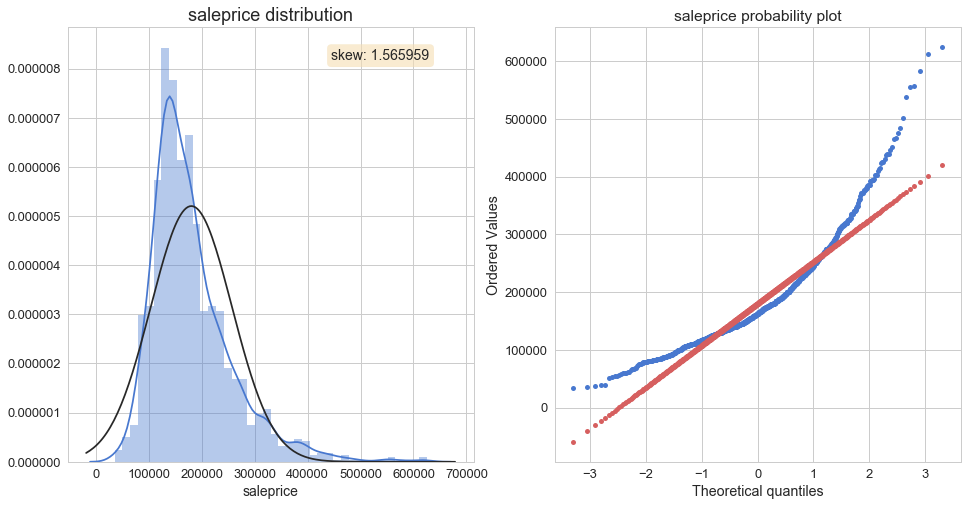

NormaltestResult(statistic=460.3067960010808, pvalue=1.1108342380647651e-100)


In [26]:
plt.figure(figsize=(16,8))

ax1 = plt.subplot(121)
sns.distplot(train['saleprice'], ax=ax1, fit=norm)
ax1.set_xlabel('saleprice', size=14)
ax1.set_title('saleprice distribution', size=18)
#text box
props = dict(boxstyle='round', color='wheat', alpha=.6)
textstr1 = 'skew: %f' % (train['saleprice'].skew())
ax1.text(0.65, 0.95, textstr1, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax2 = plt.subplot(122)
stats.probplot(train['saleprice'], plot=ax2)
ax2.set_title('saleprice probability plot')
ax2.get_lines()[0].set_marker('.')
ax2.get_lines()[0].set_markerfacecolor(color_b)
ax2.get_lines()[0].set_markersize(10)
ax2.get_lines()[1].set_linewidth(0)
ax2.get_lines()[1].set_marker('.')
ax2.get_lines()[1].set_markerfacecolor(color_r)
ax2.get_lines()[1].set_markersize(10)

plt.show()
print(stats.normaltest(a=train['saleprice']))

- saleprice is pretty far from normally distributed
- See how log transformation looks

In [27]:
print('log:', stats.normaltest(a=np.log(train['saleprice'])))
print('log1p:', stats.normaltest(a=np.log1p(train['saleprice'])))

log: NormaltestResult(statistic=17.417871145375766, pvalue=0.0001651039020773473)
log1p: NormaltestResult(statistic=17.41764459169927, pvalue=0.00016512260558467428)


- Log transforming saleprice results in a much more normal distribution
- Both log & log1p give nearly identical resuls so I'll use log1p since it plays nicer with zero's and avoids a lot of potential '-inf' values (result of trying to log zero or negative)

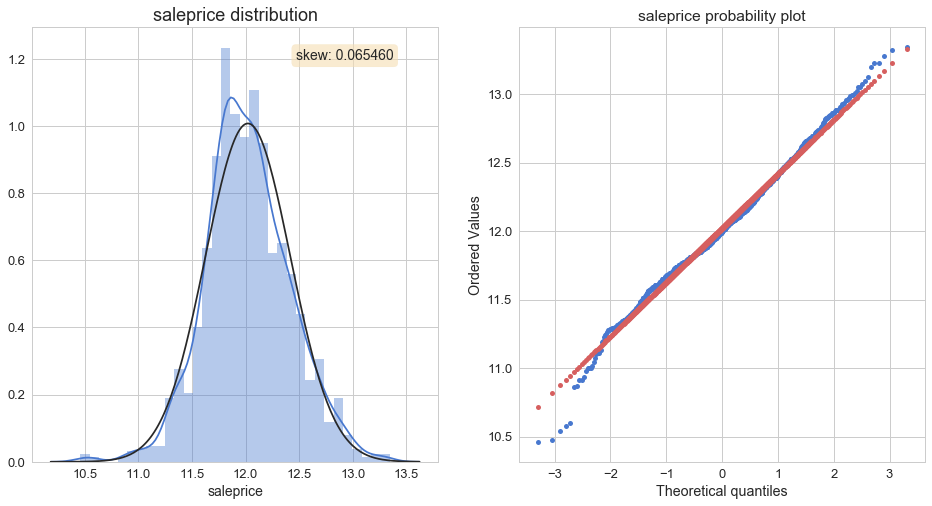

NormaltestResult(statistic=17.41764459169927, pvalue=0.00016512260558467428)


In [28]:
train['saleprice'] = np.log1p(train['saleprice'])

plt.figure(figsize=(16,8))

ax1 = plt.subplot(121)
sns.distplot(train['saleprice'], ax=ax1, fit=norm)
ax1.set_xlabel('saleprice', size=14)
ax1.set_title('saleprice distribution', size=18)
#text box
props = dict(boxstyle='round', color='wheat', alpha=.6)
textstr1 = 'skew: %f' % (train['saleprice'].skew())
ax1.text(0.65, 0.95, textstr1, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax2 = plt.subplot(122)
stats.probplot(train['saleprice'], plot=ax2)
ax2.set_title('saleprice probability plot')
ax2.get_lines()[0].set_marker('.')
ax2.get_lines()[0].set_markerfacecolor(color_b)
ax2.get_lines()[0].set_markersize(10)
ax2.get_lines()[1].set_linewidth(0)
ax2.get_lines()[1].set_marker('.')
ax2.get_lines()[1].set_markerfacecolor(color_r)
ax2.get_lines()[1].set_markersize(10)

plt.show()
print(stats.normaltest(a=train['saleprice']))

### Transform numeric variables
Since target variable saleprice has been log-transformed, model interpretability gets a little complicated unless other numeric features are log-transformed as well.
- Not basing this on a skew threshold since regression doesn't care how independent variables are distributed
- Coefficients can be interpreted as 'a x% change in beta x_i results in a y% change in y_i' (as long as the features in question have been log transformed)

In [29]:
numeric_feats = train.dtypes[train.dtypes != 'object'].index
train[numeric_feats] = np.log1p(train[numeric_feats])

## 2.6 Feature Selection
With some help from regularized linear regression

In [32]:
#create dummies
train = pd.get_dummies(train)

#train test split
X = train.loc[:, ~(train.columns).isin(['saleprice'])]
y = train['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

#evaluation functions
cv = 5

def rmse_train(model):
    rmse_train = np.sqrt(-cross_val_score(model, X_train, y_train, cv=cv,
                                          scoring='neg_mean_squared_error'))
    return(rmse_train.mean())

def rmse_test(model):
    rmse_test = np.sqrt(-cross_val_score(model, X_test, y_test, cv=cv,
                                         scoring='neg_mean_squared_error'))
    return(rmse_test.mean())

Use Lasso/L1 regularization for feature selection

In [33]:
lasso = LassoCV(alphas=[0.0001, 0.0005,
                        0.001, 0.005, 
                        0.01, 0.05, 
                        0.1, 0.5,
                        1, 5])

lasso.fit(X_train, y_train)
print('model: lasso')
print('alpha:', lasso.alpha_)
print('train rmse:', rmse_train(lasso))
print('test rmse:', rmse_test(lasso))
print('test - train = ', rmse_test(lasso) - rmse_train(lasso))

model: lasso
alpha: 0.0001
train rmse: 0.009082667001000596
test rmse: 0.010552994862549674
test - train =  0.0014703278615490773


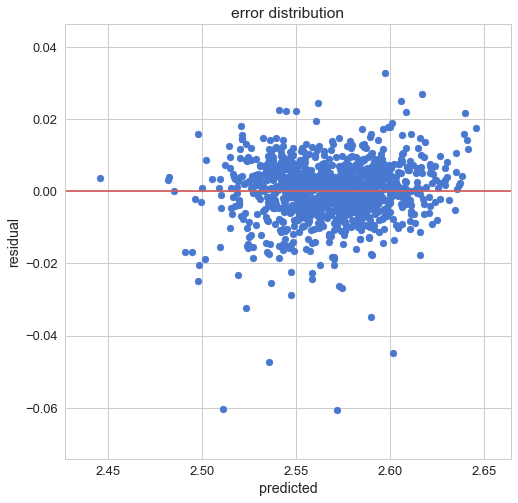

In [34]:
#check residual distribution
predicted = lasso.predict(X_train)
actual = y_train
residual = actual - predicted

plt.figure(figsize=(8,8))
plt.scatter(predicted, residual)
plt.axhline(y=0, color=color_r)
plt.xlabel('predicted')
plt.ylabel('residual')
plt.title('error distribution')
plt.show()

In [35]:
coefs = pd.Series(lasso.coef_, index=X_train.columns)
print('lasso n_components: ', str(sum(coefs != 0 )))

lasso n_components:  79


In [36]:
features = pd.DataFrame(lasso.coef_, index=X_train.columns)
features = features.reset_index()
features.columns = ['var','coef']
features = features[features['coef'] != 0]

In [37]:
features = list(features['var'])

In [38]:
X_train_feats = X_train[features]
X_test_feats = X_test[features]

In [39]:
X_train = X_train_feats
X_test = X_test_feats

# Modeling

### Random Forest Regressor

In [41]:
rfr = ensemble.RandomForestRegressor()
params = [{'n_estimators':[10, 50, 100, 250, 500],
           'max_features':[79],
           'max_depth':[10,20,30,40]}]

start_time = time.clock()
grid = GridSearchCV(estimator=rfr,
                    param_grid=params,
                    scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
print('params:', grid.best_params_)
print('runtime: ', time.clock() - start_time)

params: {'max_depth': 30, 'max_features': 79, 'n_estimators': 100}
runtime:  59.737922


In [42]:
rfr = ensemble.RandomForestRegressor(n_estimators=100,
                                     max_depth=30,
                                     max_features=79)

start_time = time.clock()
rfr.fit(X_train, y_train)

print('model: random forest')
print('train rmse:', rmse_train(rfr))
print('test rmse:', rmse_test(rfr))
print('test - train = ', rmse_test(rfr) - rmse_train(rfr))
print('runtime: ', time.clock() - start_time)

model: random forest
train rmse: 0.010619784099718203
test rmse: 0.012758736542879531
test - train =  0.002146808554148172
runtime:  10.120445000000004


### Support Vector Regressor

In [43]:
from sklearn.svm import SVR

svr = SVR()
params = [{'C':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 1, 5, 10],
           'kernel':['linear']}]

start_time = time.clock()
grid = GridSearchCV(estimator=svr,
                    param_grid=params,
                    scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
print('params:', grid.best_params_)
print('runtime: ', time.clock() - start_time)

params: {'C': 0.0001, 'kernel': 'linear'}
runtime:  0.09573700000001395


In [44]:
svr = SVR(C=0.0001, kernel='linear')
start_time = time.clock()
svr.fit(X_train, y_train)

print('model: support vector')
print('train rmse:', rmse_train(svr))
print('test rmse:', rmse_test(svr))
print('test - train = ', rmse_test(svr) - rmse_train(svr))
print('runtime: ', time.clock() - start_time)

model: support vector
train rmse: 0.03022027748853854
test rmse: 0.0353754106697767
test - train =  0.005155133181238163
runtime:  0.06035700000001043


## XGBoost Regressor

In [45]:
from xgboost import XGBRegressor

#vanilla xgb
xgb_rgr = XGBRegressor(n_estimators=1000, learning_rate=0.05)

start_time = time.clock()
xgb_rgr.fit(X_train, y_train, early_stopping_rounds=5,
            eval_set=[(X_test, y_test)], verbose=False)

print('model: xgboost regressor')
print('train rmse:', rmse_train(xgb_rgr))
print('test rmse:', rmse_test(xgb_rgr))
print('test - train = ', rmse_test(xgb_rgr) - rmse_train(xgb_rgr))
print('runtime: ', time.clock() - start_time)

model: xgboost regressor
train rmse: 0.009303541994926268
test rmse: 0.012048527352179587
test - train =  0.002744985357253319
runtime:  14.070412000000005


In [46]:
xgb_rgr = XGBRegressor()

params = [{'max_depth':[3],
           'learning_rate':[0.1, 0.05, 0.01],
           'subsample':[0.25, 0.5, 0.75, 1]}]

start_time = time.clock()
grid = GridSearchCV(estimator=xgb_rgr,
                    param_grid=params,
                    scoring='neg_mean_squared_error')

grid.fit(X_train, y_train)
print('params:', grid.best_params_)
print('runtime: ', time.clock() - start_time)

params: {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.5}
runtime:  2.9968389999999943


In [47]:
xgb_rgr = XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=3, subsample=0.5)
xgb_rgr.fit(X_train, y_train, early_stopping_rounds=5,
            eval_set=[(X_test, y_test)], verbose=False)

print('model: xgboost regressor')
print('train rmse:', rmse_train(xgb_rgr))
print('test rmse:', rmse_test(xgb_rgr))
print('test - train = ', rmse_test(xgb_rgr) - rmse_train(xgb_rgr))
print('runtime: ', time.clock() - start_time)

model: xgboost regressor
train rmse: 0.009363293596740999
test rmse: 0.01236381719176739
test - train =  0.0030005235950263907
runtime:  22.75428099999999


### Model Rankings
Model ranks by test rmse

1. Lasso
2. XGBoost (vanilla)
3. XGBoost (tuned)
4. Random Forest
5. SVR

__Are these test scores right????__